In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.makedirs("figs/pdfs", exist_ok=True)
os.makedirs("figs/pngs", exist_ok=True)

In [3]:
dataset = "cifar100"

In [4]:
data_to_ylim = {
    "cifar10": (89, 94),
    "cifar100": (68, 76),
}

ylimits = data_to_ylim[dataset]

In [5]:
plt.rcParams["font.size"] = 26
plt.rcParams["axes.grid"] = True
plt.rcParams["lines.linewidth"] = 6
plt.rcParams["savefig.facecolor"] = "white"
line_alpha = 0.85
shade_alpha = 0.15
mew = 4  # markeredgewidth
markersize = 15
marker_alpha = 0.5

In [6]:
csv_path = f"csv/{dataset}_main_results.csv"
data = pd.read_csv(csv_path)

In [7]:
if data["Mean Acc"][0] < 1:
    for col in ["Mean Acc", "Acc seed 0", "Acc seed 1", "Acc seed 2"]:
        data[col] *= 100

In [8]:
def export_legend(legend, filename="legend.png"):
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

In [9]:
COLORS = {
    "RigL": "purple",
    "SNFS": "red",
    "SET": "blue",
    "Static": "green",
    "Pruning": "brown",
    "Dense": "black",
}

In [10]:
style = {"ERK": "--", "Random": "-"}

In [11]:
inits = ["Random", "ERK"]
methods = list(COLORS.keys())
methods = sorted(methods)
methods

['Dense', 'Pruning', 'RigL', 'SET', 'SNFS', 'Static']

In [12]:
dat = data.loc[data["Method"] == "Pruning"]

In [13]:
list(dat["Init"])[0] is np.nan

True

In [14]:
def plot_runs(data, method, init, **plot_kwargs):
    """Plot accuracies for a single method + init combination."""

    dat = data.loc[data["Method"] == method]

    if method == "Dense":
        mean = np.array(dat["Mean Acc"])[0]
        stddev = np.array(dat["Std. Dev"])[0]
        line = plt.axhline(
            mean,
            alpha=line_alpha,
            **plot_kwargs,
        )
        plt.axhspan(
            mean - stddev,
            mean + stddev,
            color=line.get_color(),
            alpha=shade_alpha,
        )
        return line

    if not list(dat["Init"])[0] is np.nan:
        dat = dat.loc[dat["Init"] == init]

    x = dat["Density"]
    mean = dat["Mean Acc"]
    stddev = dat["Std. Dev"]

    (line,) = plt.plot(
        x,
        mean,
        style[init],
        alpha=line_alpha,
        **plot_kwargs,
    )

    plt.fill_between(
        x, mean - stddev, mean + stddev, facecolor=line.get_color(), alpha=shade_alpha
    )

    return line

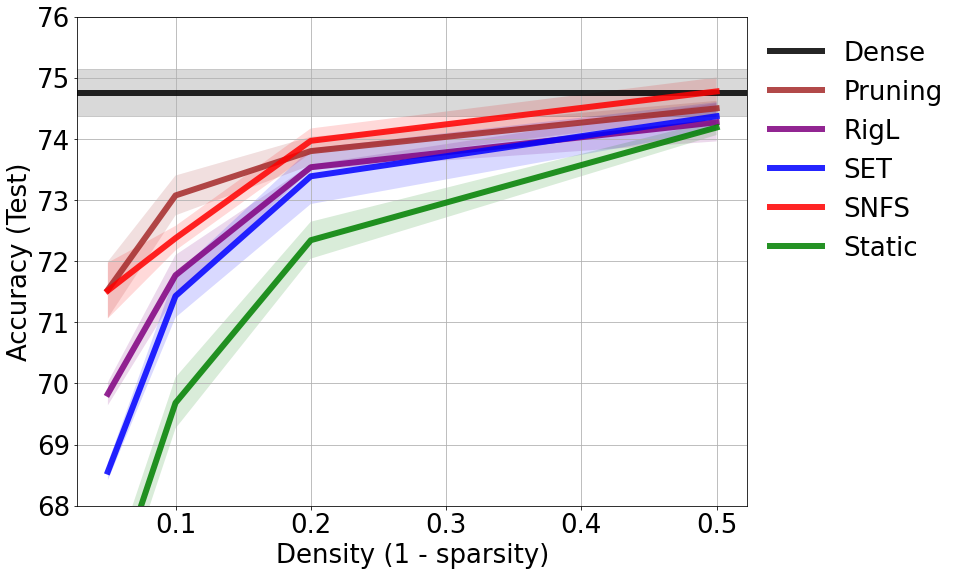

In [15]:
name = f"{dataset}_random"
plt.figure(figsize=(12, 9))
for i, method in enumerate(methods):
    a = plot_runs(
        data,
        method,
        init="Random",
        color=COLORS[method],
        #                   marker='o',
        label=method,
    )

plt.ylim(ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
# plt.title("Random Init")

plt.savefig(f"figs/pdfs/{name}.pdf", bbox_inches="tight")
plt.savefig(f"figs/pngs/{name}.png", bbox_inches="tight")

legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)
export_legend(legend, f"figs/pdfs/{name}_legend.pdf")

plt.show()

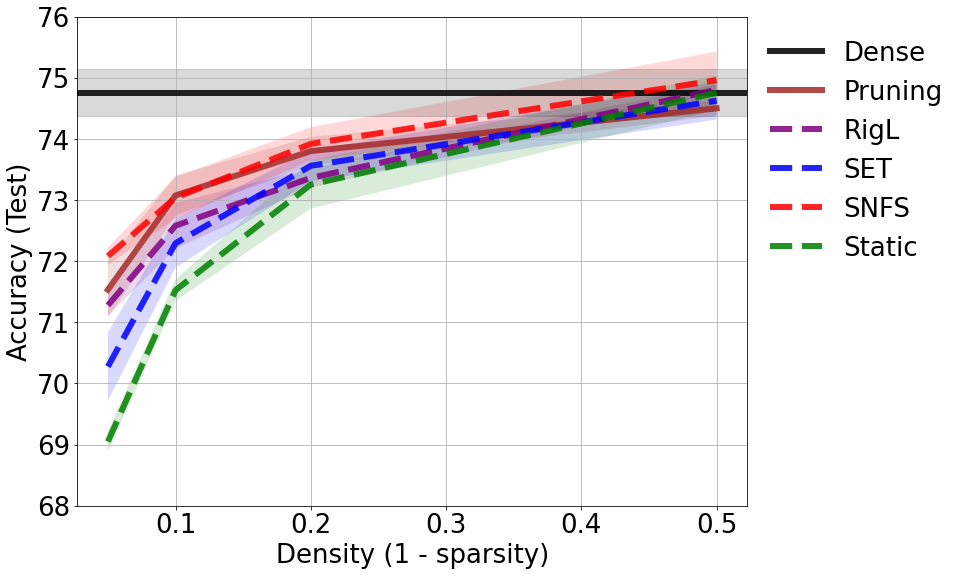

In [16]:
name = f"{dataset}_ERK"
plt.figure(figsize=(12, 9))
for i, method in enumerate(methods):
    plot_runs(
        data,
        method,
        init="Random" if method == "Pruning" else "ERK",
        color=COLORS[method],
        label=method,
    )

plt.ylim(ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
# plt.title("ERK Init")

plt.savefig(f"figs/pdfs/{name}.pdf", bbox_inches="tight")
plt.savefig(f"figs/pngs/{name}.png", bbox_inches="tight")

legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)
export_legend(legend, f"figs/pdfs/{name}_legend.pdf")

plt.show()

In [17]:
# Only for CIFAR10
if dataset == "cifar10":
    name = f"{dataset}_2x"
    plt.figure(figsize=(12, 9))

    init = "Random"
    for i, method in enumerate(["Static", "SET", "RigL"]):
        rigl_random = plot_runs(
            data, f"{method}_2x", init=init, label=f"{method}, {init}", color=COLORS[method]
        )

    init = "ERK"
    method = "RigL"
    rigl_erk = plot_runs(
        data, f"{method}_2x", init=init, label=f"{method}, {init}", color=COLORS[method]
    )


    for method in ["Pruning", "Dense"]:
        plot_runs(data, method, init="Random", label=method, color=COLORS[method])


    plt.ylim(ylimits)
    plt.xlabel("Density (1 - sparsity)")
    plt.ylabel("Accuracy (Test)")
    # plt.title("2x runs")

    plt.savefig(f"figs/pdfs/{name}.pdf", bbox_inches="tight")
    plt.savefig(f"figs/pngs/{name}.png", bbox_inches="tight")

    legend = plt.legend(
        handles=[rigl_random, rigl_erk],
        labels=inits,
        bbox_to_anchor=(1, 1),
        loc="upper left",
        frameon=False,
    )
    export_legend(legend, f"figs/pdfs/{name}_legend.pdf")

    plt.show()

---

Plots with markers for each run instead of shaded variance bounds

In [18]:
def plot_y(y_key, data, method, init, **plot_kwargs):
    """Plot a column for a single method + init combination."""

    dat = data.loc[data["Method"] == method]

    if method == "Dense":
        y = np.array(dat[y_key])[0]
        line = plt.axhline(
            y,
            **plot_kwargs,
        )
        return line

    if not list(dat["Init"])[0] is np.nan:
        dat = dat.loc[dat["Init"] == init]

    x = dat["Density"]
    y = dat[y_key]

    (line,) = plt.plot(
        x,
        y,
        style[init],
        **plot_kwargs,
    )

    return line

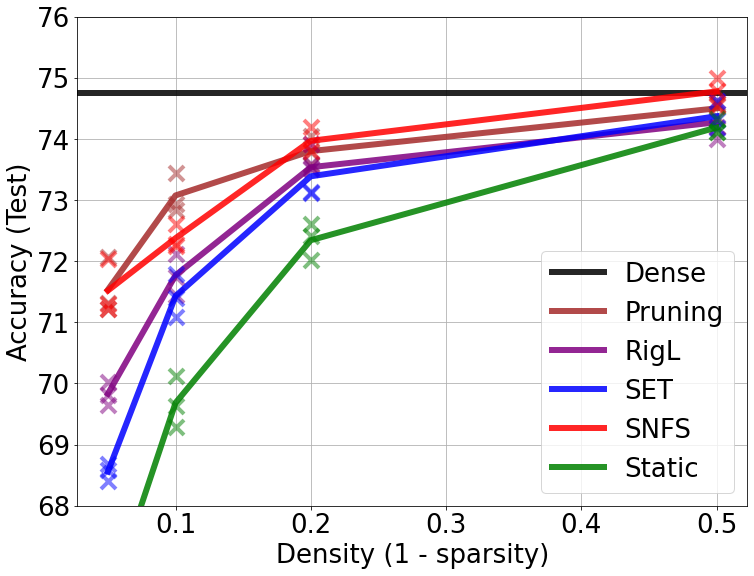

In [19]:
name = f"{dataset}_random_markers"
plt.figure(figsize=(12, 9))
for i, method in enumerate(methods):
    if method == "Dense":
        plot_y(
            "Mean Acc",
            data,
            method,
            init="Random",
            color=COLORS[method],
            label=method,
            alpha=line_alpha,
        )
        continue

    for ykey in ["Acc seed 0", "Acc seed 1", "Acc seed 2"]:
        plot_y(
            ykey,
            data,
            method,
            init="Random",
            color=COLORS[method],
            marker="x",
            markeredgewidth=mew,
            linewidth=0,
            markersize=markersize,
            alpha=marker_alpha,
        )
    plot_y(
        "Mean Acc",
        data,
        method,
        init="Random",
        color=COLORS[method],
        label=method,
        alpha=line_alpha,
    )

plt.ylim(ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
# plt.title("Random Init")
legend = plt.legend()


plt.savefig(f"figs/pdfs/{name}.pdf", bbox_inches="tight")
plt.savefig(f"figs/pngs/{name}.png", bbox_inches="tight")

# legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)
export_legend(legend, f"figs/pdfs/{name}_legend.pdf")

plt.show()

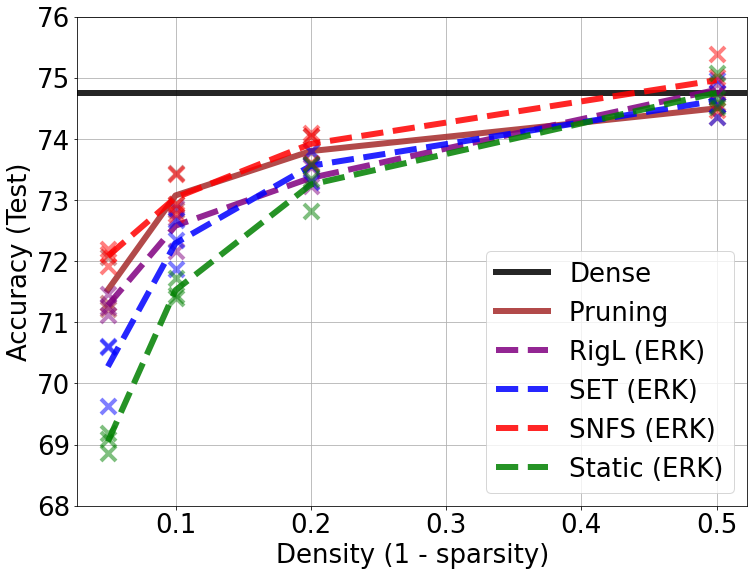

In [20]:
name = f"{dataset}_ERK_markers"
plt.figure(figsize=(12, 9))
for i, method in enumerate(methods):
    if method == "Dense":
        plot_y(
            "Mean Acc",
            data,
            method,
            init="Random",
            color=COLORS[method],
            alpha=line_alpha,
            label=method,
        )
        continue

    for ykey in ["Acc seed 0", "Acc seed 1", "Acc seed 2"]:
        plot_y(
            ykey,
            data,
            method,
            color=COLORS[method],
            init="ERK",
            marker="x",
            markeredgewidth=mew,
            linewidth=0,
            markersize=markersize,
            alpha=marker_alpha,
        )
    plot_y(
        "Mean Acc",
        data,
        method,
        init="Random" if method == "Pruning" else "ERK",
        color=COLORS[method],
        label=f"{method} {'' if method == 'Pruning' else '(ERK)'}",
        alpha=line_alpha,
    )

plt.ylim(ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
# plt.title("ERK Init")
legend = plt.legend(frameon=True)


plt.savefig(f"figs/pdfs/{name}.pdf", bbox_inches="tight")
plt.savefig(f"figs/pngs/{name}.png", bbox_inches="tight")

# legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)


export_legend(legend, f"figs/pdfs/{name}_legend.pdf")

plt.show()

In [21]:
# For CIFAR10 only
if dataset == "cifar10":
    name = f"{dataset}_2x_markers"
    plt.figure(figsize=(12, 9))


    method = "Dense"
    plot_y(
        "Mean Acc",
        data,
        method,
        init="Random",
        color=COLORS[method],
        label=method,
        alpha=line_alpha,
    )

    method = "Pruning"
    for ykey in ["Acc seed 0", "Acc seed 1", "Acc seed 2"]:
        plot_y(
            ykey,
            data,
            f"{method}",
            color=COLORS[method],
            init="Random",
            marker="x",
            markeredgewidth=mew,
            linewidth=0,
            markersize=markersize,
            alpha=marker_alpha,
        )
    plot_y(
        "Mean Acc",
        data,
        f"{method}",
        init=init,
        color=COLORS[method],
        label=method,
        alpha=line_alpha,
    )


    init = "ERK"
    method = "RigL"
    for ykey in ["Acc seed 0", "Acc seed 1", "Acc seed 2"]:
        plot_y(
            ykey,
            data,
            f"{method}_2x",
            color=COLORS[method],
            init=init,
            marker="x",
            markeredgewidth=mew,
            linewidth=0,
            markersize=markersize,
            alpha=marker_alpha,
        )
    plot_y(
        "Mean Acc",
        data,
        f"{method}_2x",
        init=init,
        color=COLORS[method],
        label=f"{method} (ERK)",
        alpha=line_alpha,
    )

    init = "Random"
    for i, method in enumerate(["RigL", "SET", "Static"]):
        for ykey in ["Acc seed 0", "Acc seed 1", "Acc seed 2"]:
            plot_y(
                ykey,
                data,
                f"{method}_2x",
                color=COLORS[method],
                init=init,
                marker="x",
                markeredgewidth=mew,
                linewidth=0,
                markersize=markersize,
                alpha=marker_alpha,
            )
        plot_y(
            "Mean Acc",
            data,
            f"{method}_2x",
            init=init,
            color=COLORS[method],
            label=method,
            alpha=line_alpha,
        )


    plt.ylim(ylimits)
    plt.xlabel("Density (1 - sparsity)")
    plt.ylabel("Accuracy (Test)")
    # plt.title("2x runs")

    plt.legend()

    plt.savefig(f"figs/pdfs/{name}.pdf", bbox_inches="tight")
    plt.savefig(f"figs/pngs/{name}.png", bbox_inches="tight")

    plt.show()

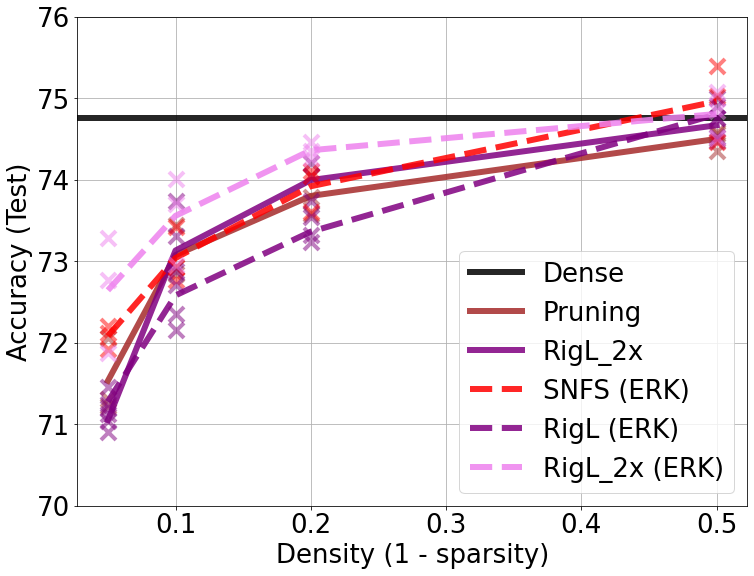

In [24]:
# Plotting the following runs:
# Dense
# Pruning 
# RigL 2x 
# SNFS ERK 
# RigL ERK
# RigL ERK 2x

name = f"{dataset}_ERKand2x_markers"
plt.figure(figsize=(12, 9))


# Dense
method = "Dense"
plot_y(
    "Mean Acc",
    data,
    method,
    init="Random",
    color=COLORS[method],
    label=method,
    alpha=line_alpha,
)

method_inits_colors = [
    ("Pruning", "Random", COLORS["Pruning"]),    
    ("RigL_2x", "Random", COLORS["RigL"]),


    ("SNFS", "ERK", COLORS["SNFS"]),
    ("RigL", "ERK", COLORS["RigL"]),
    ("RigL_2x", "ERK", "violet"),
]

for method, init, color in method_inits_colors:
    for ykey in ["Acc seed 0", "Acc seed 1", "Acc seed 2"]:
        plot_y(
            ykey,
            data,
            method,
            color=color,
            init=init,
            marker="x",
            markeredgewidth=mew,
            linewidth=0,
            markersize=markersize,
            alpha=marker_alpha,
        )
    plot_y(
        "Mean Acc",
        data,
        method,
        init=init,
        color=color,
        label=method + (" (ERK)" if init=="ERK" else ""),
        alpha=line_alpha,
    )


plt.ylim((70,76) if dataset == "cifar100" else ylimits)
plt.xlabel("Density (1 - sparsity)")
plt.ylabel("Accuracy (Test)")
legend = plt.legend(frameon=True)


plt.savefig(f"figs/pdfs/{name}.pdf", bbox_inches="tight")
plt.savefig(f"figs/pngs/{name}.png", bbox_inches="tight")


export_legend(legend, f"figs/pdfs/{name}_legend.pdf")

plt.show()

In [23]:
# plt.subplots(1, 2, figsize=(20, 8))
# plt.subplot(1, 2, 1)
# lines = {}
# for init in inits:
#     for i, method in enumerate(methods):
#         dat = data.loc[(data['Method'] == method) & (data['Init'] == init)]
#         lines[init], = plt.plot(dat['Density'], dat['Mean Acc'],
#                                 style[init],
#                                 color=COLORS[method],)

# dat = data.loc[(data['Method'] == 'Pruning')]
# plt.plot(dat['Density'], dat['Mean Acc'], color=COLORS['Pruning'])

# plt.ylim(0.88, 0.94)
# plt.xlabel("Density (1 - sparsity)")
# plt.ylabel("Accuracy (Test)")

# plt.subplot(1, 2, 2)
# for init in inits:
#     for i, method in enumerate(methods):
#         dat = data.loc[(data['Method'] == method+'_2x')
#                        & (data['Init'] == init)]
#         plt.plot(dat['Density'], dat['Mean Acc'],
#                  style[init],
#                  color=COLORS[method],
#                  label=method if init == 'Random' else None)

# dat = data.loc[(data['Method'] == 'Pruning')]
# plt.plot(dat['Density'], dat['Mean Acc'],
#          color=COLORS['Pruning'], label='Pruning')
# plt.ylim(0.88, 0.94)
# plt.xlabel("Density (1 - sparsity)")
# plt.ylabel("Accuracy (Test)")
# plt.title("2x runs")


# methods_leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
# plt.gca().add_artist(methods_leg)
# plt.legend(handles=lines.values(), labels=lines.keys(),
#            loc='upper left', bbox_to_anchor=(1.02, 0.5))
# # legend(bbox_to_anchor=(1.05, 1), loc='center left')

# plt.tight_layout()
# plt.savefig("figs/dataset_main.png", bbox_inches='tight')
# plt.show()